In [1]:

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
from sklearn.utils import shuffle
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import cv2
import gradio as gr
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
image_dir = 'Dataset/Images'
caption_dir = 'Dataset/captions.txt'
jpgs = os.listdir(image_dir)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


In [3]:
data = pd.read_csv(caption_dir, names = ['filename', 'caption'])
index = np.asanyarray([0, 1, 2, 3, 4] * len(jpgs))
data.insert(1, column = 'index', value = index)
uni_filenames = np.unique(data.filename.values)

In [4]:
data.head(10)

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,0,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,1,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,2,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,3,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,4,Two dogs on pavement moving toward each other .


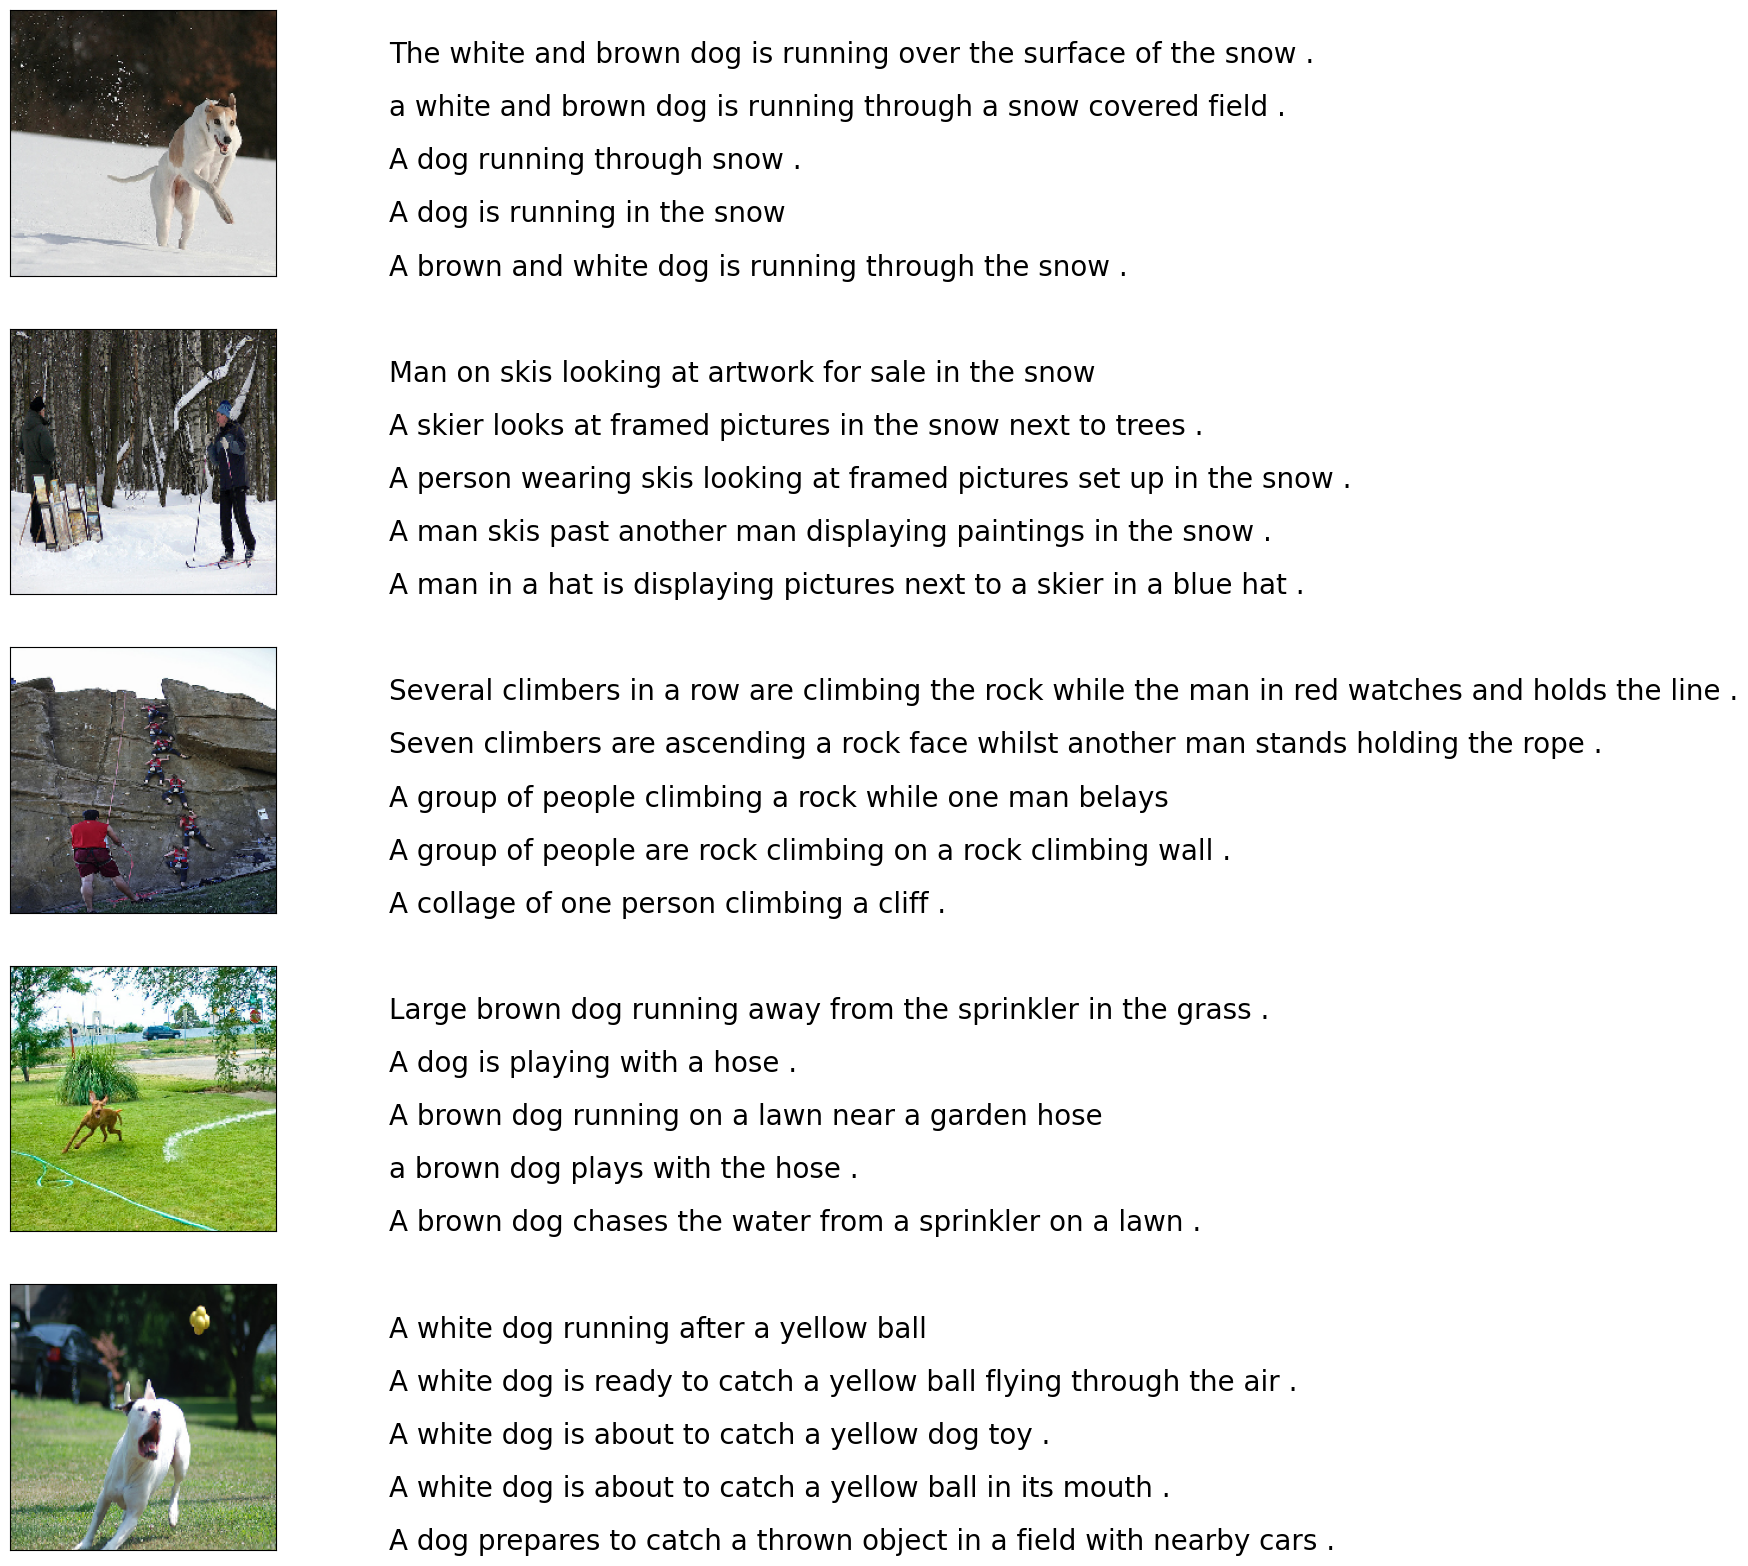

In [5]:
npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:15]:
    filename = image_dir + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [6]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))
ct = Counter(vocabulary)
ct.keys()

Vocabulary Size: 9630


dict_keys(['A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'an', 'entry', 'way', '.', 'girl', 'going', 'into', 'wooden', 'building', 'little', 'playhouse', 'the', 'to', 'her', 'cabin', 'black', 'dog', 'and', 'spotted', 'are', 'fighting', 'tri-colored', 'playing', 'with', 'each', 'other', 'on', 'road', 'white', 'brown', 'spots', 'staring', 'at', 'street', 'Two', 'dogs', 'different', 'breeds', 'looking', 'pavement', 'moving', 'toward', 'covered', 'paint', 'sits', 'front', 'painted', 'rainbow', 'hands', 'bowl', 'sitting', 'large', 'small', 'grass', 'plays', 'fingerpaints', 'canvas', 'it', 'There', 'pigtails', 'painting', 'Young', 'outside', 'man', 'lays', 'bench', 'while', 'his', 'by', 'him', 'which', 'also', 'tied', 'sleeping', 'next', 'shirtless', 'lies', 'park', 'laying', 'holding', 'leash', 'ground', 'orange', 'hat', 'starring', 'something', 'wears', 'glasses', 'gauges', 'wearing', 'Blitz', 'beer', 'can', 'crocheted', 'The', 'pierced', 'ears', 

In [7]:
all_captions = []
for caption  in data["caption"].astype(str):
    words = list(caption.split())
    if '.' in words:
        index = words.index('.')
        words.pop(index)
        words = [word.lower() for word in words]
        caption = ' '.join(words)
    caption = 'startseq ' + caption + ' endseq'
    all_captions.append(caption)
all_captions[:10]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq',
 'startseq A black dog and a spotted dog are fighting endseq',
 'startseq a black dog and a tri-colored dog playing with each other on the road endseq',
 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [8]:
all_img_name_vector = []
PATH = 'Dataset/Images/'
for annot in data["filename"]:
    full_image_path = PATH + annot
    all_img_name_vector.append(full_image_path)
all_img_name_vector[:10]

['Dataset/Images/1000268201_693b08cb0e.jpg',
 'Dataset/Images/1000268201_693b08cb0e.jpg',
 'Dataset/Images/1000268201_693b08cb0e.jpg',
 'Dataset/Images/1000268201_693b08cb0e.jpg',
 'Dataset/Images/1000268201_693b08cb0e.jpg',
 'Dataset/Images/1001773457_577c3a7d70.jpg',
 'Dataset/Images/1001773457_577c3a7d70.jpg',
 'Dataset/Images/1001773457_577c3a7d70.jpg',
 'Dataset/Images/1001773457_577c3a7d70.jpg',
 'Dataset/Images/1001773457_577c3a7d70.jpg']

In [9]:
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

In [10]:
num_examples = 40000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]
print(f"priviously we had {len(all_captions)} captions, and Now we have {len(train_captions)}.")

priviously we had 40455 captions, and Now we have 40000.


In [11]:
from keras.applications.vgg16 import VGG16, preprocess_input

In [12]:

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

In [13]:
image_model = tf.keras.applications.VGG16(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [14]:
image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [15]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)
print(f"Let's check the BatchDataset shapes--> {image_dataset}")

Let's check the BatchDataset shapes--> <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [16]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [17]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['padseq'] = 0
tokenizer.index_word[0] = 'padseq'
train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
print(cap_vector.shape)

(40000, 39)


In [18]:

max_length = calc_max_length(train_seqs)
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [19]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32000, 32000, 8000, 8000)

In [20]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [21]:
def map_func(img_name, cap):
  tmp = img_name.__str__()
  a = tmp[tmp.index('b') + 2 : tmp.index('.jpg') + 4]
  a = list(a.split('/'))
  p_new = 'Save' + '/' + 'Image_feature' + '/' + a[2]
  img_tensor = np.load(p_new + '.npy')
  return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [22]:
class Attention(tf.keras.Model):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [23]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [24]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = Attention(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [25]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [27]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
  loss = 0
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * BATCH_SIZE, 1)
  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)
  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return loss, total_loss

In [ ]:
EPOCHS = 30
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    loss_plot.append(total_loss / num_steps)

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
encoder.save_weights('Save/Test_encoder/encoder.npy')
decoder.save_weights('Save/Test_decoder/decoder.npy')

In [28]:
def evaluate(image):
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, 
                                                 img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['startseq']], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == 'endseq':
            return ' '.join(result)
        dec_input = tf.expand_dims([predicted_id], 0)
    return ' '.join(result)

In [33]:
new_encoder = CNN_Encoder(embedding_dim)
new_decoder = RNN_Decoder(embedding_dim, units, vocab_size)
new_encoder.load_weights('Save/Test_encoder/encoder.npy')
new_decoder.load_weights('Save/Test_decoder/decoder.npy')

In [32]:
def fn(image):
    caption_len = 15
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    temp_input = tf.expand_dims(image, 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = new_encoder(img_tensor_val)
    hidden = new_decoder.reset_state(batch_size=1)
    dec_input = tf.expand_dims([tokenizer.word_index['startseq']], 0)
    result = []
    for i in range(caption_len):
        predictions, hidden, _ = new_decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == 'endseq':
            result.pop(-1)
            return ' '.join(result)
        dec_input = tf.expand_dims([predicted_id], 0)
    result.pop(-1)
    return ' '.join(result)
interface = gr.Interface(fn = fn,
    inputs=gr.components.Image(),
    outputs=gr.Textbox(label="Predicted caption"),
)
interface.queue()
interface.launch(share = True, debug = True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://8b6919fd32d30d85d9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8b6919fd32d30d85d9.gradio.live
